The specific NLP task at hand is called "semantic search" under the field of information retrieval.

Potential features:
- Personally, I wouldn't let people see the whole database cuz nothing good comes out of it
- What'd be really cool (& attention capturing) is if we could do multiple searches at once. Split queries by `'\n'` & return columns of distinct search results
- Have maximum length be 100 characters. Encourages succinctness & for users to split separate problems into separate queries.
- Have template start with "My client needs ..." followed by some examples. Encourages users to focus on the help they would like to receive, not the problem they have or how things will worsen should the problem remain unchecked.
- Bold keywords from query if they are present in description
- Autocomplete
- Autocorrect
- If website tracks IP address, for very similar queries within short timespan, return different results
- Scold people for vague queries, e.g. "The more specific you are with your search, the more likely a relevant scheme can be properly identified. Don't worry, we do NOT collect any identifiable information from users."
- SchemesSG could eventually function as a gapfinder, identifying gaps in social support for common problems

In [3]:
import pickle
import numpy as np
import nltk
import re
import string
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', 200)

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim import corpora, models, similarities

from sentence_transformers import SentenceTransformer, util
from sentence_transformers.cross_encoder import CrossEncoder

from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
%matplotlib inline

biencoder = SentenceTransformer('paraphrase-distilroberta-base-v2')
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

df = pd.read_csv('../schemes2.csv', encoding='cp1252')
df.drop(columns = ['Link', 'Background Image Link'], inplace = True)
df['Text'] = df['Description'] + ' ' + df['Who\'s it for']
df['Text1'] = df['Description'] + ' ' + df['What it gives']
df['Text2'] = df['Description'] + ' ' + df['search_booster(WL)'].astype(str)
df['Text3'] = df['Description'] + ' ' + df['Who\'s it for'] + ' ' + df['What it gives'] + ' ' + df['search_booster(WL)'].astype(str)

def Cleaner(text):
    '''Input: df(str); Output: df([str, str])'''
    wn = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ['nan']
    punc = string.punctuation.replace('$', '')
    
    # Get rid of weird encoding like non-ASCII characters 
    text = ''.join([i if (i in string.printable) & (i not in punc) else ' ' for i in text.lower()])
    text = re.sub('\n|-|\s+', ' ', text)
    tokens = re.split(' ', text.strip())
    tokens = [wn.lemmatize(i) for i in tokens if i not in stopwords]
    return tokens

df['Tokens'] = df['Description'].apply(Cleaner)
df['Tokens0'] = df['Text'].apply(Cleaner)
df['Tokens1'] = df['Text1'].apply(Cleaner)
df['Tokens2'] = df['Text2'].apply(Cleaner)
df['Tokens3'] = df['Text3'].apply(Cleaner)
df

,Title,Agency,Description,Who's it for,What it gives,Scheme Type,search_booster(WL),Text,Text1,Text2,Text3,Tokens,Tokens0,Tokens1,Tokens2,Tokens3
0,Caregiver Training Program,Caregivers Alliance,Provides training to caregivers of persons with mental health issues,Caregivers,Educational programmes for caregivers,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope anymore. Sandwich generation,Provides training to caregivers of persons with mental health issues Caregivers,Provides training to caregivers of persons with mental health issues Educational programmes for caregivers,Provides training to caregivers of persons with mental health issues Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope anymore. Sandwich generation,Provides training to caregivers of persons with mental health issues Caregivers Educational programmes for caregivers Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope a...,"[provides, training, caregiver, person, mental, health, issue]","[provides, training, caregiver, person, mental, health, issue, caregiver]","[provides, training, caregiver, person, mental, health, issue, educational, programme, caregiver]","[provides, training, caregiver, person, mental, health, issue, caregiver, feeling, overwhelmed, burnout, elderly, parent, stress, cannot, cope, anymore, sandwich, generation]","[provides, training, caregiver, person, mental, health, issue, caregiver, educational, programme, caregiver, caregiver, feeling, overwhelmed, burnout, elderly, parent, stress, cannot, cope, anymor..."
1,Caregivers Support Centre,Caregivers Alliance,Provides support to caregivers of persons with mental health issues,Caregivers,Emotional care,"Caregiver,Mental Health",Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope anymore. Sandwich generation,Provides support to caregivers of persons with mental health issues Caregivers,Provides support to caregivers of persons with mental health issues Emotional care,Provides support to caregivers of persons with mental health issues Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope anymore. Sandwich generation,Provides support to caregivers of persons with mental health issues Caregivers Emotional care Caregivers feeling overwhelmed. Burnout. Elderly parent. Stress. Cannot cope anymore. Sandwich generation,"[provides, support, caregiver, person, mental, health, issue]","[provides, support, caregiver, person, mental, health, issue, caregiver]","[provides, support, caregiver, person, mental, health, issue, emotional, care]","[provides, support, caregiver, person, mental, health, issue, caregiver, feeling, overwhelmed, burnout, elderly, parent, stress, cannot, cope, anymore, sandwich, generation]","[provides, support, caregiver, person, mental, health, issue, caregiver, emotional, care, caregiver, feeling, overwhelmed, burnout, elderly, parent, stress, cannot, cope, anymore, sandwich, genera..."
2,Family LifeAid,Red Cross Singapore,"Identified households receive food vouchers every month. Households will benefit from supplementary support, such as storytelling, tutoring of young children and helping the seniors with household...","Low income,Need food support","Financial assistance,Food,Educational programmes","Low Income,Food,Education","needs help to get food, meal, hungry, have not eaten for days. Child needs tuition but no money. Need childcare. Elderly need help with household chores.","Identified households receive food vouchers every month. Households will benefit from supplementary support, such as storytelling, tutoring of young children and helping the seniors with household...","Identified households receive food vouchers every month. Households will benefit from supplementary support, such as storytelling, tutoring of young children and helping the seniors with household...","Identified households receive food vouchers every month

# Short-Term Evaluation
## Internal validity
### 1. Internal validity check #1
    - Overfitting accuracy should be very high; if a model can't even overfit, it is useless.
    - More relevant for hyperparameter tuning in unsupervised (LSI) & self-supervised (Doc2Vec) learning methods.
    - Test set == Training set. How often can a model identify that the document most similar to a document is itself?
    - Generally anything >95% is satisfactory; the magnitude beyond 95% is meaningless.
    - All models are satisfactory in this regard.
### 2. Internal validity check #2
    - Articles deemed similar to a document should have overlapping labels.
    - Assumes labels are good (If labels aren't good, this can help with clustering). Limited to labels that appear more than once.
    - Currently there are lenient & strict versions. The lenient version checks if similar documents contain at least 1 label from the reference document. The strict version checks if similar documents contain all the labels from the reference document.
    - Strict version is more important; but since we're currently not too sure about the quality of labels, keep the lenient version for now.
    - Doc2Vec is best in this regard, hitting ≈77.6% on the strict version, though the rest are close behind.
    - The Transformers do better under sparsity, while document vectors & LSI do better with as many columns included as possible.

In [2]:
classes = ','.join(df['Scheme Type'].values).split(',')
classes = {k : v for k, v in Counter(classes).items() if v > 1}
classes

{'Caregiver': 13,
 'Mental Health': 9,
 'Low Income': 54,
 'Food': 19,
 'Education': 16,
 'Healthcare': 35,
 'PWD': 10,
 'Transport': 10,
 'Tech': 5,
 'Family': 27,
 'Childcare': 7,
 'Elderly': 12,
 'Work': 2,
 'Student Care': 2,
 'Loss of Breadwinner': 4,
 'COVID-19': 6,
 'Housing': 14,
 'Special Needs': 4,
 'End-of-Life': 3,
 'Youth-at-Risk': 7,
 'Children': 4,
 'Homeless': 4,
 'Family Violence': 4,
 ' Debt': 3,
 'Women': 3,
 'Legal Aid': 3}

In [3]:
# In future I might refactor the roberta_sim() & cross_sim() functions to support individual queries without needing new code.
def d2v_sim(d2v, text):
    '''Similarity function for Doc2Vec; outputs row indices of top 4 similarities'''
    vec = d2v.infer_vector(text)
    sim = d2v.docvecs.most_similar([vec], topn = 4)
    return np.array(sim)[:, 0]

def lsi_sim(dic, lsi, corpus, text):
    '''Similarity function for Latent Semantic Indexing; outputs row indices of top 4 similarities'''
    vec_bow = dic.doc2bow(text)
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sim = sorted(enumerate(index[vec_lsi]), key = lambda i : -i[1])
    return np.array(sim)[:4, 0]

def roberta_sim(i, embeddings, text):
    '''Similarity function for roBERTa; outputs row indices of top 4 similarities
    Technically can output queries all at once, but comparing labels still needs a loop anyway'''
    return np.argsort(-np.array(sim.cpu())[i])[:4]

def cross_sim(crossencoder, text, df = df):
    '''Similarity function for MS MARCO cross encoder; outputs row indices of top 4 similarities'''
    sim = crossencoder.predict([(text, df['Description'][i]) for i in range(len(df))])
    return np.argsort(-sim)[:4]

def internal_validity(func, col, df = df, classes = classes, kwargs = {}):
    '''Implements internal validity checks 1 & 2. Takes similarity functions as input'''
    count = count1 = count2 = 0

    for i, label, text in df[['Scheme Type', col]].itertuples():
        sim = func(text = text, **kwargs)

        if sim[0] == i:
            count += 1
        
        labels = [j for j in label.split(',') if j in classes]
        labels2 = df.loc[sim[sim != i], 'Scheme Type'].values
        labels2 = ','.join(labels2).split(',')

         # Lenient version:
        if any(k in labels2 for k in labels):
            count1 += 1
        # Strict version:
        if all(k in labels2 for k in labels):
            count2 += 1
        
    return count, count1, count2

In [6]:
results = []

for col in ['Tokens', 'Tokens0', 'Tokens1', 'Tokens2', 'Tokens3']:
    dic = corpora.Dictionary(df[col])
    corpus = [dic.doc2bow(i) for i in df[col]]
    tfidf = models.TfidfModel(corpus, id2word = dic)
    corpus = tfidf[corpus]
    lsi = models.LsiModel(corpus, id2word = dic, num_topics = 300)
    count, count1, count2 = internal_validity(func = lsi_sim, col = col, kwargs = {'dic' : dic, 'lsi' : lsi, 'corpus' : corpus})
    results.append([col, 'Latent Semantic Indexing', count, count1, count2])
    
    docs = [TaggedDocument(doc, [i]) for i, doc in df[[col]].itertuples()]
    d2v = Doc2Vec(docs, dm = 0, vector_size = 300, window = 10, min_count = 1, epochs = 200, seed = 117)
    count, count1, count2 = internal_validity(func = d2v_sim, col = col, kwargs = {'d2v' : d2v})
    results.append([col, 'Doc2Vec', count, count1, count2])
    
#for col in ['Description', 'Text', 'Text1', 'Text2', 'Text3']:
#    embeddings = biencoder.encode(df[col].values, convert_to_tensor = True)
#    embeddings = util.pytorch_cos_sim(embeddings, embeddings)
#    count, count1, count2 = internal_validity(func = roberta_sim, col = col, kwargs = {'i' : i, 'embeddings' : embeddings})
#    results.append([col,'paraphrase-distilroberta-base-v2', count, count1, count2])
    
    # Warning: This block takes really long even with GPU
#    count, count1, count2 = internal_validity(func = cross_sim, col = col, kwargs = {'crossencoder' : crossencoder})
#    results.append([col, 'cross-encoder/ms-marco-MiniLM-L-12-v2', count, count1, count2])

temp = pd.DataFrame(results, columns = ['Columns Used', 'Model', 'Overfitting Accuracy', '≥1 Label Present', 'All Labels Present'])
temp.sort_values(by = ['Model', 'Columns Used'], inplace = True)
temp.iloc[:, -3:] /= len(df)
# temp.to_csv('Tune1.csv', index = False)
# temp = temp.melt(id_vars = ['Columns Used', 'Model'], var_name = 'Metric', value_name = 'Score')
# temp = temp.pivot_table(index = ['Metric', 'Columns Used'], columns = 'Model', values = 'Score')
temp.style.background_gradient(cmap = 'Blues')

,Columns Used,Model,Overfitting Accuracy,≥1 Label Present,All Labels Present
1,Tokens,Doc2Vec,0.987500,0.875000,0.668750
3,Tokens0,Doc2Vec,0.987500,0.893750,0.725000
5,Tokens1,Doc2Vec,0.987500,0.893750,0.756250
7,Tokens2,Doc2Vec,0.987500,0.918750,0.731250
9,Tokens3,Doc2Vec,0.987500,0.912500,0.768750
0,Tokens,Latent Semantic Indexing,0.993750,0.906250,0.693750
2,Tokens0,Latent Semantic Indexing,0.993750,0.875000,0.681250
4,Tokens1,Latent Semantic Indexing,0.993750,0.893750,0.756250
6,Tokens2,Latent Semantic Indexing,0.993750,0.918750,0.750000
8,Tokens3,Latent Semantic Indexing,0.993750,0.918750,0.750000


# Additional notes
- LSI code refactored by referencing documentation [here](https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html).

### Doc2Vec hyperparameter tuning:
- $\approx$5 minutes for 135 models on 1 CPU core
- Consistent with past experiences, epochs matters most & higher is generally better (though slightly longer to train)
- Vector size doesn't matter when epochs are high

# Short-term Evaluation - External Validity
- Incredibly tedious to go through every scheme & label by hand, so what I've done for now is relative evaluation
- Sample out representative queries, cluster them by hand & go through 1 by 1 to see which model returns more relevant results
- Even from the 1st few results, it was obvious Doc2Vec was outclassed, so I didn't bother going on
- Main comparisons are between [cross encoder](https://www.sbert.net/examples/applications/cross-encoder/README.html) trained on Bing search data & the [roBERTa](https://www.sbert.net/docs/pretrained-models/ce-msmarco.html) paraphrasing model JY used
- In retrospect, all the earlier proxies using internal validity turned out to be un-indicative of how a model will actually perform live, but at least now we know

In [12]:
# temp1 = pd.read_csv('Query.csv')
# temp1 = temp1['Query'][temp1['Query'].notna()]
# temp1.drop_duplicates(inplace = True)
# temp1.sample(100).to_csv('Query sample.csv', index = False)

In [2]:
search = '2 years old, cannot communicate with others'
col = 'Description'

embeddings = biencoder.encode(df[col].values, convert_to_tensor = True)
query = biencoder.encode(search, convert_to_tensor = True)
sim = util.pytorch_cos_sim(query, embeddings)
df.iloc[np.argsort(-sim.cpu()[0])[:3], :3]

NameError: name 'crossencoder' is not defined

In [7]:
sim1 = crossencoder.predict([(search, df[col][i]) for i in range(len(df))])
df.iloc[np.argsort(-sim1)[:3], :3]

,Title,Agency,Description
62,Home Access Programme,Infocomm Media Development Authority (IMDA),"Home Access provides eligible Singaporean families with 2 years of subsidised fibre broadband connectivity. Families without full-time student may choose to bundle the broadband, with a tablet or ..."
147,Various services,Clarity Singapore Limited,"Provides rehabilitation and emotional support for those aged 16 years and above struggling with mental health conditions such as anxiety, depression, stress, arising from bereavement and loss, rel..."
141,Various services,Goodlife!,"Network for people with dementia and depression, as well as caregivers who need the additional support to care for their loved ones. Provides appropriate mental health care and social support netw..."


# Evaluation Results
- All in all, cross encoder is best. Beyond counting, whenever cross encoder is best, it tends to be **substantially** better than the alternatives.

| Which is better? | How often? | (%) |
| --- | :-: | :-: |
| Cross encoder | 23 | 45% |
| roBERTa | 13 | 25% |
| Equally good | 8 | 16% |
| Equally okay | 1 | 2.0% |
| Both suck | 4 | 7.8% |
| ... no idea | 2 | 3.9% |

- Seems like cross encoder does better when searches are specific & succinct. Lengthy queries sometimes confuse it & this is where roBERTa occasionally performs better.
- roBERTa's results are decent & we could offer them as alternatives if users don't like what is returned. E.g. in the long-term if we evaluate based on whether a user clicked or not, those clicks will likely to be biased towards whatever the cross encoder recommended, which could form an echo chamber. Perhaps for each response, randomly pick 1 of roBERTa's top 3 to be included.
- That said, occasionally, roBERTa tends to return results that users may find offensive, e.g. searches for shelter return results about aging in-place, searches for disability employment return schemes for those permanently unable to work, searches for intellectually impaired kids unable to communicate return schemes that are self-help hotlines.
- Seems like cross encoder does better when asked to search through just `df['Descriptions']`. When including information from nearly all columns, i.e. `df['Text3']`, performance drops slightly to roBERTa levels. But I haven't tested this extensively.

| Search | Best Model | Remarks |
| --- | --- | --- |
| "cyberbullying kid" | Cross encoder | Was able to identify the 2 most relevant schemes even when given columns that don't contain "cyberbullying" |
| "sinda" | Cross encoder | Top 3 results all SINDA |
| "homeless elderly" | Cross encoder | Both identified top choice, but roBERTa's 2nd choice was about aging in-place in community. For this, prolly better to use all columns because searchers tend to ask about "shelter", not "homelessness" |
| "Client needs accommodation but does not want joint single scheme" | Cross encoder | Top 3 results all HDB |
| "My client is a child that is being neglected by parents." | Cross encoder | Child protection, youth services. roBERTa returned home ownership & legal clinic |
| "My client needs food." | Equally good | There are a lot of food assistance schemes |
| "food in sengkang" | ... no idea | Cross encoder returned financial assistance schemes in Seng Kang, roBERTa returned food schemes |
| "cancer patient no job" | roBERTa | Top 2 the same, roBERTa's 3rd choice more relevant |
| "Looking for a crisis shelter for domestic abuse and financial aid after loss of job" | Both suck | Too many things in 1 query |
| "Looking for a crisis shelter for domestic abuse" | Cross encoder | |
| "financial aid after loss of job" | Equally good | A lot of choices. But both did not return anything specific to COVID |
| "My client is a single mother who was abused by her husband. She needs financial support for her baby" | ... no idea | Cross encoder focused on 1st sentence, roBERTa focused on 2nd |
| "I need money to pay my mom\'s cancer treatment bills. I have already borrowed $50,000 from loan sharks and they say if I don\'t pay them back next week, they will go to the hospital and \'become the cancer,\' please help!" | roBERTa | Cross encoder focused on debt assistance |
| "I need money to pay my mom\'s cancer treatment bills" | Cross encoder | Top 3 results all cancer-related (only top 2 for roBERTa) |
| "My client needs assistance as a dialysis patient. She is also in need of a job and financial support after COVID 19 has caused her to be retrenched" | Cross encoder | 1 of the uncommon instances where cross encoder exactly answers both |
| "cancer patient no job" | roBERTa | Top 2 the same, roBERTa's 3rd choice better |
| "diabetes" | Cross encoder | But both aren't great |
| "caregiver with no income" | Both suck | roBERTa sucks a little less |
| "financial assistance for caregivers" | roBERTa | roBERTa returned schemes to help caregivers themselves. Cross encoder focused on subsidies for engaging caregiver services |
| "career counselling, youth" | Cross encoder | Cross encoder slightly better |
| "career counseling, youth" | Cross encoder | Cross encoder much better, likely because it doesn't rely on training set embeddings (which are in British english) |
| "Client is a kidney dialysis patient and self empowered but jobless" | Cross encoder | |
| "retrenched due to covid 19" | Equally good | A lot of choices |
| "I am fired cos i broke a law" | roBERTa | roBERTa included legal aid & temporary housing for ex-offenders. Both understand informal language. |
| "I was fired cos i broke the law" | roBERTa | Thankfully results are stable even with grammatical variation |
| "Mature and can't find job | roBERTa | roBERTa slightly better, though both focused on financial rather than job assistance |
| "financial assistance for students" | Cross encoder | Both good, but cross encoder focused specifically on students |
| "Financial assistance for children" | Equally good | A lot of choices |
| "childcare fees help" | Cross encoder | Both good, but cross encoder returned more diverse options |
| "My client needs financial assistance with her young children's basic needs." | Equally okay | Both don't exactly get the point |
| "business employee" | Both suck | I'm assuming the user's an employer looking up grants for hiring/retaining employees. No relevant scheme in database. |
| "insolvency" | Both suck | Query was way too vague. The database does have various legal aid schemes, though none explicitly concerned with insolvency. |
| "financial support for young couple" | Cross encoder | Both not great. No relevant scheme in database. |
| "need laptop" | Equally good | |
| "funeral fee" | Cross encoder| |
| "women empowerment" | Cross encoder | |
| "elderly with disability" | roBERTa | Both are good |
| "My uncle needs some end of life care" | roBERTa | Identified palliative care scheme |
| "Mother needs nursing home" | roBERTa | Both good; roBERTa's 3rd choice better |
| "my elderly clients needs nursing home care due to high medical needs. my client also needs subsidy for the nursing home" | Equally good | Query is long-winded |
| "My client needs assistance with caregiving as her elderly mother has to undergo pediatric dialysis, and her daughter has Lupus. My client herself is also diagnosed with the Kikuchi disease. She faces acute caregiving stress and require assistance in caregiving and homemaking. " | roBERTa | Again, roBERTa tends to do better with longer, high-dimensional queries |
| "My client faces acute caregiving stress and require assistance in caregiving and homemaking." | Equally good | |
| "assisted living for cancer" | Equally good | |
| "eldercare" | Cross encoder | |
| "depression help for youths" | Cross encoder | Both good, but cross encoder returned more diverse options |
| "dementia transport" | Cross encoder | |
| "intellectual impairment" | roBERTa | Slightly better than cross encoder. But query is vague |
| "Counseling support for wife in divorce staying in yishun" | roBERTa | Both good, but roBERTa returned more diverse options |
| "My client lost spouse to suicide and is need of specialist bereavement support." | Cross encoder | |
| "disabilities employment" | Cross encoder | |
| "adult child is depressed and hides in his room" | Cross encoder | Both good |

### Possible clustering of `df['Scheme Type']` for another day:
1. Use roBERTa encodings as word vectors
2. Use kMeans to get clusters
3. Dimensionality reduction using UMAP to plot on scatter plot
4. Color point using clusters from kMeans

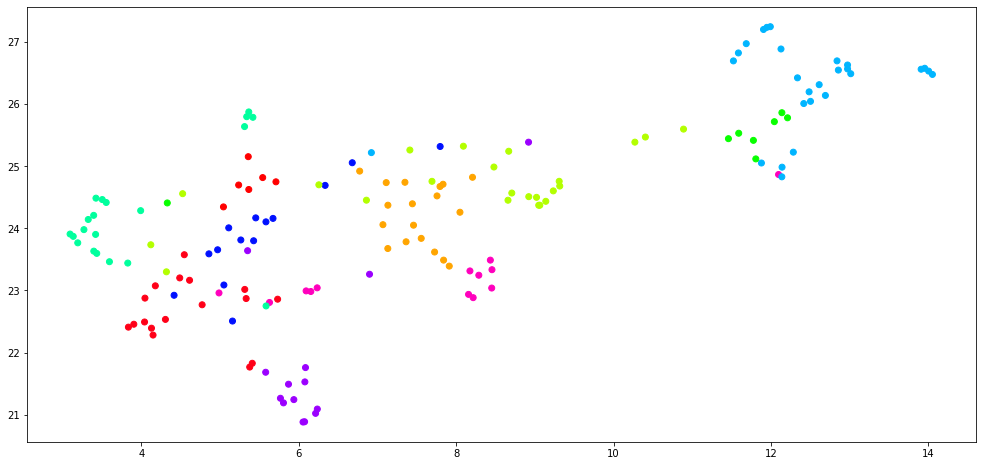

In [9]:
embeddings = biencoder.encode(df['Text3'].values, convert_to_tensor = False)
plt.rcParams.update({'figure.figsize' : (17, 8)})

kmeans = KMeans(n_clusters = 10,
                max_iter = 3000,
                random_state = 117).fit(embeddings)

fit = umap.UMAP(metric = 'cosine',
                min_dist = .1,
                n_epochs = 5000,
                n_neighbors = 6,
                n_components = 2,
                random_state = 117,
                transform_seed = 117)

vectors = fit.fit_transform(embeddings)
plt.scatter(vectors[:, 0], vectors[:, 1], c = kmeans.labels_, cmap = 'hsv')

In [7]:
print(gensim.__version__)

3.8.3


In [5]:
import gensim
print(gensim.__version__)

3.8.3
